# Backtesting a Moving Average Crossover Strategy for Bitcoin

This notebook demonstrates a simple backtesting framework for a moving average crossover trading strategy applied to Bitcoin. It downloads 2 years of daily BTC-USD price data, uses an API function from `moving_avg_api.py` to generate trading signals, simulates a trading strategy, and then compares its performance with a buy-and-hold strategy.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Add the parent directory to sys.path to import moving_avg_api.py
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from moving_avg_api import moving_average_crossover_signal

# For inline plotting in Jupyter
%matplotlib inline

## Downloading Bitcoin Price Data

We will download 2 years of daily Bitcoin (BTC-USD) price data using the `yfinance` library.

In [2]:
# Define the time period for data download
end_date = datetime.today()
start_date = end_date - timedelta(days=730)  # Approximately 2 years

# Download historical daily price data for Bitcoin (BTC-USD)
btc_data = yf.download('BTC-USD', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
print("Raw Data Head:")
print(btc_data.head())

# Extract the 'Close' column using the full MultiIndex key and ensure it's a Series
if ('Close', 'BTC-USD') not in btc_data.columns:
    raise KeyError("The downloaded data does not contain the expected MultiIndex key ('Close', 'BTC-USD').")
close_series = btc_data[('Close', 'BTC-USD')].squeeze()

# Convert the 'Close' column to numeric (ensuring it's 1D) and drop any NaN values
close_series = pd.to_numeric(close_series, errors='coerce')
btc_data[('Close', 'BTC-USD')] = close_series
btc_data = btc_data.dropna(subset=[('Close', 'BTC-USD')])

# Reset the index so that dates are available as a column for plotting
btc_data.reset_index(inplace=True)

print("Cleaned Data Head:")
print(btc_data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Raw Data Head:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2023-03-26  27994.330078  28178.144531  27445.046875  27495.523438   
2023-03-27  27139.888672  28037.925781  26606.689453  27994.068359   
2023-03-28  27268.130859  27460.718750  26677.818359  27132.888672   
2023-03-29  28348.441406  28619.542969  27259.662109  27267.031250   
2023-03-30  28033.562500  29159.902344  27720.160156  28350.140625   

Price            Volume  
Ticker          BTC-USD  
Date                     
2023-03-26  13878363192  
2023-03-27  18188895178  
2023-03-28  17783600385  
2023-03-29  20684945906  
2023-03-30  22435349951  
Cleaned Data Head:
Price        Date         Close          High           Low          Open  \
Ticker                  BTC-USD       BTC-USD       BTC-USD       BTC-USD   
0      2023-03-26  27994.330078  28178.1445

## Backtesting the Moving Average Crossover Strategy

We use the following parameters for the strategy:

- **short_window**: 20 days
- **long_window**: 50 days

The algorithm (via `moving_average_crossover_signal`) examines the historical closing prices and returns a signal:

- **BUY**: If yesterday the short moving average was below (or equal to) the long moving average and today it has crossed above it.
- **SELL**: If yesterday the short moving average was above (or equal to) the long moving average and today it has crossed below it.
- **HOLD**: Otherwise, no trading action.

The simulation will run through the data daily. When a **BUY** signal occurs and you are not in the market, you invest all available capital. When a **SELL** signal occurs and you hold a position, you liquidate your entire position. For comparison, a buy-and-hold strategy is also computed.

In [3]:
# Set parameters for the moving average crossover
short_window = 20
long_window = 50

# Initialize lists to store the signals and portfolio values
signals = [None] * len(btc_data)
portfolio_values = []

# Initial capital (in USD) for trading simulation
initial_capital = 1000.0
capital = initial_capital
position = 0.0  # This will hold the number of BTC purchased

# Use the 'Close' prices for the simulation, extracted from the MultiIndex column.
# Convert to a list of built-in Python floats.
close_prices = [float(x) for x in btc_data[('Close', 'BTC-USD')].values.tolist()]

for i in range(len(close_prices)):
    # Not enough data to compute the moving averages for the first few days
    if i < long_window + 1:
        signals[i] = None
    else:
        # Use the price history up to and including the current day.
        # (They are already floats, so this list will satisfy the API.)
        price_history = close_prices[:i+1]
        signal = moving_average_crossover_signal(
            price_history, 
            short_window, 
            long_window,
            min_valid_price=1000, 
            max_valid_price=200000
        )
        signals[i] = signal
    
    current_price = close_prices[i]
    # Execute trades based on the signal once enough data is available
    if i >= long_window + 1:
        if signals[i] == "BUY" and position == 0:
            # Buy BTC with all available capital
            position = capital / current_price
            capital = 0
        elif signals[i] == "SELL" and position > 0:
            # Sell all BTC
            capital = position * current_price
            position = 0

    # The portfolio value is the cash if not in position, or the current value of BTC if holding
    portfolio_value = capital if position == 0 else position * current_price
    portfolio_values.append(portfolio_value)

# Add the signals and portfolio values as new columns to our DataFrame
btc_data['Signal'] = signals
btc_data['Portfolio Value'] = portfolio_values

# Display the last few rows to verify
btc_data.tail()


Price,Date,Close,High,Low,Open,Volume,Signal,Portfolio Value
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
725,2025-03-20,84167.195312,87443.265625,83647.195312,86872.953125,29028988961,HOLD,1963.305457
726,2025-03-21,84043.242188,84782.273438,83171.070312,84164.539062,19030452299,HOLD,1963.305457
727,2025-03-22,83832.484375,84513.875000,83674.781250,84046.257812,9863214091,HOLD,1963.305457
728,2025-03-23,86054.375000,86094.781250,83794.914062,83831.898438,12594615537,HOLD,1963.305457
729,2025-03-24,87498.914062,88758.726562,85541.195312,86070.929688,34582604933,HOLD,1963.305457


## Buy-and-Hold Strategy Comparison

For comparison, we compute a simple buy-and-hold strategy. In this approach, we invest the entire initial capital on the first day when our simulation begins (i.e. once we have enough data) and hold that position until the end of the period.

In [4]:
# Determine the first valid day index for the simulation
buy_hold_start_index = long_window + 1
buy_hold_start_price = close_prices[buy_hold_start_index]

# Calculate the portfolio value for a buy-and-hold strategy
buy_hold_values = [None] * len(close_prices)
for i in range(len(close_prices)):
    if i < buy_hold_start_index:
        buy_hold_values[i] = initial_capital
    else:
        buy_hold_values[i] = initial_capital * (close_prices[i] / buy_hold_start_price)

btc_data['Buy & Hold'] = buy_hold_values
btc_data[['Close', 'Buy & Hold']].tail()

Price,Close,Buy & Hold
Ticker,BTC-USD,
725,84167.195312,3113.077770
726,84043.242188,3108.493137
727,83832.484375,3100.697874
728,86054.375000,3182.878565
729,87498.914062,3236.307486


## Performance Analysis and Visualizations

### 1. BTC Price Chart with Trading Signals

This chart shows the Bitcoin closing prices along with markers indicating where the strategy signaled a **BUY** or **SELL**.

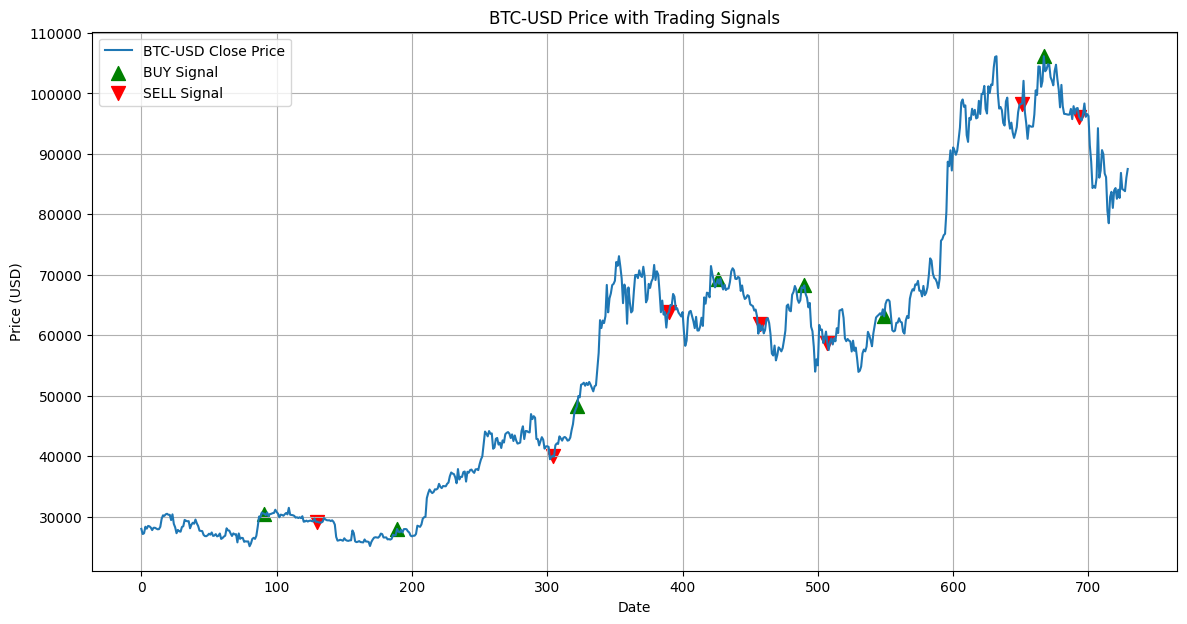

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['Close'], label='BTC-USD Close Price')

# Plot BUY signals
buy_signals = btc_data[btc_data['Signal'] == 'BUY']
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='BUY Signal', s=100)

# Plot SELL signals
sell_signals = btc_data[btc_data['Signal'] == 'SELL']
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='SELL Signal', s=100)

plt.title('BTC-USD Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 2. Portfolio Value Comparison

The next chart compares the portfolio value over time for our moving average strategy versus a buy-and-hold strategy.

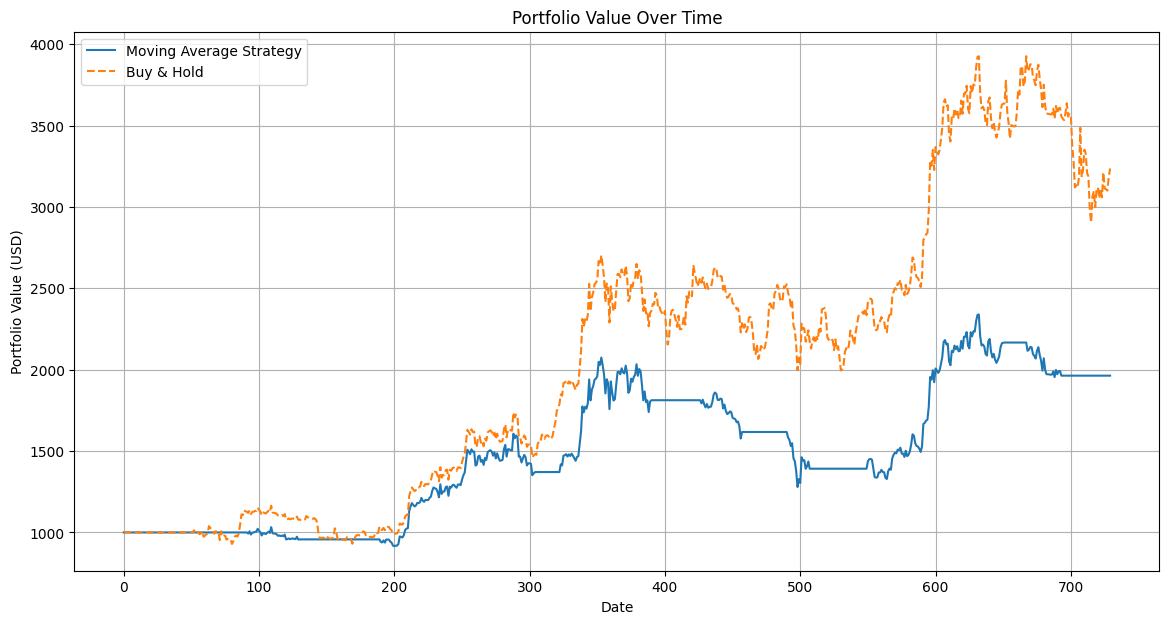

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['Portfolio Value'], label='Moving Average Strategy')
plt.plot(btc_data.index, btc_data['Buy & Hold'], label='Buy & Hold', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 3. Performance Metrics

We calculate basic performance metrics including the total return and the Compound Annual Growth Rate (CAGR) for both strategies.

In [7]:
def calculate_performance(values):
    total_return = (values[-1] - values[0]) / values[0] * 100
    # CAGR assuming daily data
    cagr = ((values[-1] / values[0]) ** (365 / len(values)) - 1) * 100
    return total_return, cagr

# Drop any None values that might be present at the beginning
algo_values = btc_data['Portfolio Value'].dropna().tolist()
bh_values = btc_data['Buy & Hold'].dropna().tolist()

algo_return, algo_cagr = calculate_performance(algo_values)
bh_return, bh_cagr = calculate_performance(bh_values)

print(f"Moving Average Strategy Total Return: {algo_return:.2f}%")
print(f"Moving Average Strategy CAGR: {algo_cagr:.2f}%")
print(f"Buy & Hold Total Return: {bh_return:.2f}%")
print(f"Buy & Hold CAGR: {bh_cagr:.2f}%")

Moving Average Strategy Total Return: 96.33%
Moving Average Strategy CAGR: 40.12%
Buy & Hold Total Return: 223.63%
Buy & Hold CAGR: 79.90%


## Conclusion

In this notebook we:

- Downloaded two years of daily Bitcoin price data.
- Used a simple moving average crossover strategy (via an API function) to generate trading signals.
- Simulated daily trades based on these signals and computed the resulting portfolio value.
- Compared the performance of the algorithm against a buy-and-hold strategy using visualizations and performance metrics.

This framework provides a basic starting point for backtesting trading strategies. For real-world applications, further considerations such as transaction costs, slippage, and risk management should be incorporated.